# Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans
import cv2
import tensorflow as tf
from skimage import img_as_uint
import keras.backend as K
import matplotlib.pyplot as plt


from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras import layers

In [3]:
Sky = [128, 128, 128]
Building = [128, 0, 0]
Pole = [192, 192, 128]
Road = [128, 64, 128]
Pavement = [60, 40, 222]
Tree = [128, 128, 0]
SignSymbol = [192, 128, 128]
Fence = [64, 64, 128]
Car = [64, 0, 128]
Pedestrian = [64, 64, 0]
Bicyclist = [0, 128, 192]
Unlabelled = [0, 0, 0]

dictionary = np.array([Sky, Building, Pole, Road, Pavement,
                       Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

In [58]:
def adjustData(img, mask, flag_multi_class, num_class):
    if (flag_multi_class):
        img = img / 255
        mask = mask[:, :, :, 0] if (len(mask.shape) == 4) else mask[:, :, 0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            # for one pixel in the image, find the class in mask and convert it into one-hot vector
            # index = np.where(mask == i)
            # index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            # new_mask[index_mask] = 1
            new_mask[mask == i, i] = 1
            new_mask = np.reshape(new_mask, (new_mask.shape[0], new_mask.shape[1] * new_mask.shape[2],
                                         new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask, 
                                        (new_mask.shape[0] * new_mask.shape[1], new_mask.shape[2]))
        mask = new_mask
    elif np.max(img) > 1:
        img = img / 255
        mask = mask / 255
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0
    return img, mask

In [71]:
def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode="grayscale",
                   mask_color_mode="grayscale", image_save_prefix="image", mask_save_prefix="mask",
                   flag_multi_class=False, num_class=2, save_to_dir=None, target_size=(256, 256),
                   seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
         directory=train_path,
          target_size=target_size,
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=True,
          classes=['NoSpill', 'Oilspill'],
          save_to_dir=save_to_dir,
          save_prefix=image_save_prefix,
          seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
     directory=train_path,
     target_size=target_size,
     batch_size=batch_size,
     class_mode='categorical',
     shuffle=True,
     classes=['NoSpill', 'Oilspill'],
     save_to_dir=save_to_dir,
     save_prefix=mask_save_prefix,
     seed=seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield img, mask

In [72]:
def testGenerator(test_path, target_size=(256, 256), flag_multi_class=False):
    for i in glob.glob(test_path):
        img = cv2.imread(i)
        image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = image_gray / 255.
        img = trans.resize(img, target_size)
        img = np.reshape(img, img.shape + (1,)) if (not flag_multi_class) else img
        img = np.reshape(img, (1,) + img.shape)
        yield img

In [73]:
def geneTrainNpy(image_path, mask_path, flag_multi_class=False, num_class=2, image_prefix="image", mask_prefix="mask",
                 image_as_gray=True, mask_as_gray=True):
    image_name_arr = glob.glob(os.path.join(image_path, "%s*.png" % image_prefix))
    image_arr = []
    mask_arr = []
  
    for index, item in enumerate(image_name_arr):
        img = io.imread(item, as_gray=image_as_gray)
        img = np.reshape(img, img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path, mask_path).replace(image_prefix, mask_prefix), as_gray=mask_as_gray)
        mask = np.reshape(mask, mask.shape + (1,)) if mask_as_gray else mask
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr, mask_arr

In [74]:
def dice_loss():
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        return numerator / denominator

    return loss

In [75]:
def jaccard_coef():
    def loss1(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

    return loss1

In [76]:
def labelVisualize(num_class, color_dict, img):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = color_dict[i]
    return img_out

In [77]:
def saveResult(save_path, npyfile, flag_multi_class=False, num_class=2):
    for i, item in enumerate(npyfile):
        img = labelVisualize(num_class, dictionary, item) if flag_multi_class else item[:, :, 0]
        io.imsave(os.path.join(save_path, "%d_predict.tif" % i), img_as_uint(img))

#Model

In [78]:
def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), jaccard_coef()])

    # model.summary()

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model


# Data Prepare

In [121]:
#if you don't want to do data augmentation, set data_gen_args as an empty dict.
# data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(100,'/content/drive/MyDrive/Data_sets/PETR/Spill_Data/_mask_train_/','image','label',data_gen_args,save_to_dir = "/content/drive/MyDrive/Data_sets/PETR/Spill_Data/aug/")

### Train with data generator

In [120]:
model = None
model = unet()
model_checkpoint = ModelCheckpoint('unet_oilspill.hdf5', monitor='loss',verbose=1, save_best_only=True)

### Train with npy file

In [122]:
imgs_train,imgs_mask_train = geneTrainNpy("/content/drive/MyDrive/Data_sets/PETR/Spill_Data/aug/","/content/drive/MyDrive/Data_sets/PETR/Spill_Data/aug/")
history = model.fit(imgs_train, imgs_mask_train, batch_size=8, epochs=10, verbose=1, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint])

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.4789 - mean_io_u_14: 0.3078 - loss1: 0.5719  
Epoch 1: loss improved from inf to 0.61407, saving model to unet_oilspill.hdf5
2/2 [==============================] - 162s 87s/step - loss: 0.6141 - accuracy: 0.4789 - mean_io_u_14: 0.3078 - loss1: 0.5719 - val_loss: 0.6238 - val_accuracy: 0.1773 - val_mean_io_u_14: 0.4114 - val_loss1: 0.6221
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.3845 - mean_io_u_14: 0.3078 - loss1: 0.4758  
Epoch 2: loss improved from 0.61407 to 0.52660, saving model to unet_oilspill.hdf5
2/2 [==============================] - 161s 82s/step - loss: 0.5266 - accuracy: 0.3845 - mean_io_u_14: 0.3078 - loss1: 0.4758 - val_loss: 0.6059 - val_accuracy: 0.1773 - val_mean_io_u_14: 0.4114 - val_loss1: 0.5939
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.5082 - mean_io_u_14: 0.3078 - loss1: 0.4400  
Epoch 3: 

### test your model and save predicted results

In [111]:
testGene = testGenerator("/content/drive/MyDrive/Data_sets/PETR/Spill_Data/Test_2/*")
model = unet()
model.load_weights("unet_oilspill.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("/content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/",results)

<ipython-input-111-34ef18c50a70>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(testGene,30,verbose=1)


30/30 [==============================] - 76s 3s/step


<ipython-input-77-e6a539a76b74>:4: UserWarning: /content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/0_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d_predict.tif" % i), img_as_uint(img))
<ipython-input-77-e6a539a76b74>:4: UserWarning: /content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/1_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d_predict.tif" % i), img_as_uint(img))
<ipython-input-77-e6a539a76b74>:4: UserWarning: /content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/2_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d_predict.tif" % i), img_as_uint(img))
<ipython-input-77-e6a539a76b74>:4: UserWarning: /content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/3_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d_predict.tif" % i), img_as_uint(img))
<ipython-input-77-e6a539a76b74>:4: UserWarning: /content/drive/MyDrive/Data_sets/PETR/Spill_Data/results/4_predict.tif i

In [112]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_288 (Conv2D)            (None, 256, 256, 64  640         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_289 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_288[0][0]']             
                                )                                                          

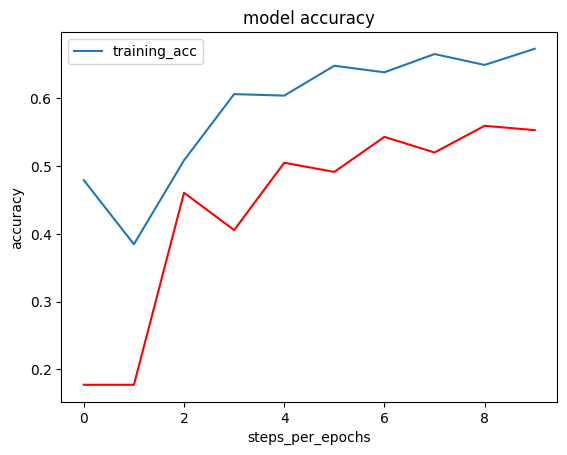

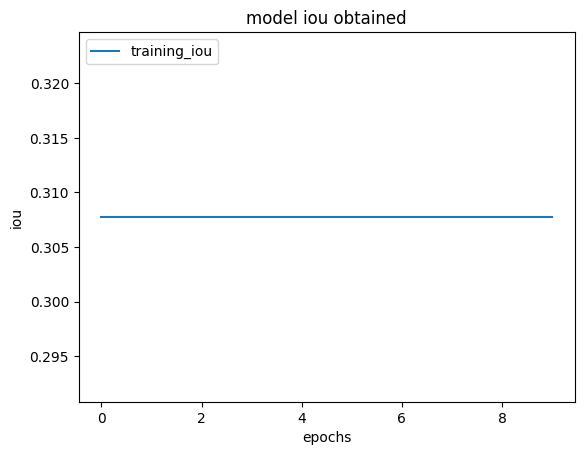

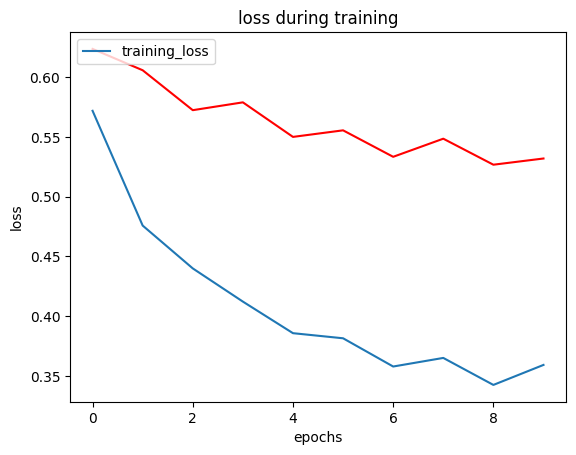

In [124]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],color='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps_per_epochs')
plt.legend(['training_acc'], loc="upper left")
plt.show()

plt.figure(2)
plt.plot(history.history['mean_io_u_14'])
plt.title('model iou obtained')
plt.ylabel('iou')
plt.xlabel('epochs')
plt.legend(['training_iou'], loc="upper left")
plt.show()

plt.figure(3)
plt.plot(history.history['loss1'])
plt.plot(history.history['val_loss'],color='r')
plt.title('loss during training')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training_loss'], loc="upper left")
plt.show()